In [1]:
%matplotlib inline
import scrublet as scr
import scipy.io
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
import math
from scipy import sparse
from scipy import interpolate
from patsy import dmatrix
import statsmodels.api as sm

## Load Data 

In [2]:
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
pandas2ri.activate()

readRDS = robjects.r['readRDS']
dataList = readRDS('../data/Robjects/ExpressionList_QC_matrix.rds')
cells = dataList[1]
cells = pandas2ri.ri2py_dataframe(cells)
genes = dataList[2]
genes = pandas2ri.ri2py_dataframe(genes)
m = dataList[0]
m = np.asarray(m)
sfs = pd.read_csv('../data/Robjects/SizeFactors.csv')
#m = m.transpose()

In [3]:
# Normalize m
keepCells = [x==1 for x in cells.PassAll]
m = m[:,keepCells]
cells = cells[keepCells]
keepGenes = np.mean(m,axis=1) > 0.01
genes = genes[keepGenes]
m = m[keepGenes,:]
m = m / np.ravel(np.asarray(sfs.sf))
m = np.log10(m+1)
m = sparse.csc_matrix(m)
m = m.transpose()

In [4]:
print(m.shape)
print(cells.shape)
print(genes.shape)
set(cells['Condition'])

(60023, 12103)
(60023, 15)
(12103, 7)


{'CBLT',
 'WKBR61.4dM',
 'WKBR61.4dT',
 'WKBR65.2f',
 'WKBR65.2g',
 'WKBR65.3g',
 'WKBR65.3h',
 'WKBR65.3i'}

In [5]:
# Subset to one Condition for Doublet testing
#condition = "ctrl"
#selection = [i==condition for i in cells['Condition']]
#cells = cells[selection]
#m = m[np.array(selection),]
#print(m.shape)
#print(cells.shape)

## Feature selection


In [6]:
keepGenes = [x==1 for x in genes.KeepForHvg]

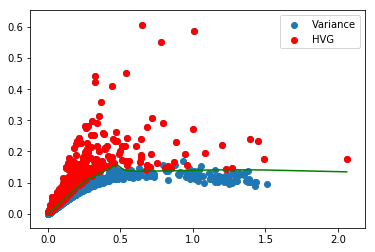

In [7]:
genes['Mean'] = np.ravel(np.array(np.mean(m,axis=0),ndmin=1))
genes['Variance'] = np.ravel(np.array(m.todense().var(0),ndmin=1))
# Spline 1 doesnt work
#tck = interpolate.splrep(x=x, y=y)
#vals = interpolate.splev(x=x_new, tck=tck, der=0)
#plt.scatter(x_new,vals)
# Spline2 doesnt work
#transformed_x1 = dmatrix("cr(x, df=6)", {"x": x}, return_type='dataframe')
#fit1 = sm.GLM(y, transformed_x1).fit()
#pred1 = fit1.predict(dmatrix("cr(x_new, df=6)",{"x_new": x_new}, return_type='dataframe'))
#plt.scatter(x, y)
#plt.plot(x_new, pred1, color='g', label='Natural spline df=6')
#plt.legend()
# Try lowess
pred = sm.nonparametric.lowess(endog=genes.Variance, exog=genes.Mean, it=1, frac=0.1)
plt.scatter(genes.Mean, genes.Variance)
plt.plot(pred[:,0], pred[:,1], 'g-')

# Identify the top 10% of genes with the highest residual variance
forres = sm.nonparametric.lowess(endog=genes.Variance,exog=genes.Mean, it=1, frac=0.1, return_sorted=False)
genes['Residuals'] = np.subtract(genes.Variance,forres)
hvg = genes[keepGenes]
ngenes = round(genes.shape[0]/10)
hvg = hvg.sort_values(by='Residuals', ascending=False)[:ngenes]
plt.scatter(hvg.Mean, hvg.Variance, color='red', label="HVG")
plt.legend()
gene_index = np.where(list(genes.id.isin(hvg.id)))[0]

## Dimenisionality Reuciton using UMAP

In [24]:
import umap
embedding = umap.UMAP(n_neighbors=15, metric='correlation', random_state=42,
                     min_dist=0.5).fit_transform(m[:,gene_index])

In [30]:
# Save as .csv file
cells['UMAP1'] = embedding[:,0]
cells['UMAP2'] = embedding[:,1]
cells.to_csv(path_or_buf='../data/Robjects/UMAP_all.csv',columns=['barcode','UMAP1','UMAP2'])

In [10]:
#anno = pd.read_csv('../data/Robjects/BRCA1_Cluster.csv')
#cells = pd.merge(cells, anno, left_on="barcode", right_on="barcode",how="left")

In [11]:
#?np.place(np.array(cells.Colors),cells.Colors=="dodgerblue4","red")
#set(cells.Colors)

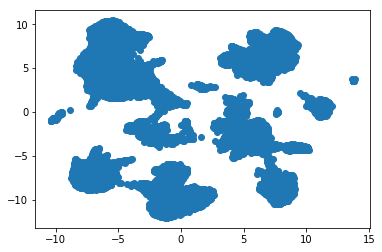

In [25]:
#cluster = cells['SubClusterNumbers']
#cluster = [x[1:3] for x in cluster]
#cluster = np.array(cluster)
#fig1 = plt.figure()
plt.scatter(embedding[:,0], embedding[:,1])#, c=cells.Colors, s=2)
#tcks = list(set(cluster))
#tcks = [float(i) for i in tcks]
#plt.colorbar(label="Cluster",ticks=tcks)

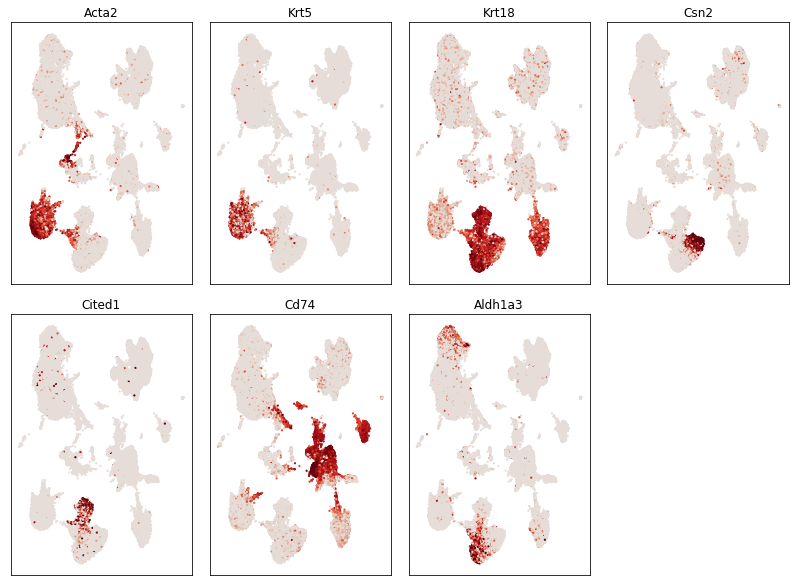

In [26]:
genes_to_plot = ['Acta2', 'Krt5', 'Krt18', 'Csn2', 'Cited1', 'Cd74', 'Aldh1a3']
symbols = genes['symbol']
x = embedding[:,0]
y = embedding[:,1]

ncol = 4
nrow = len(genes_to_plot) / ncol + 1
fig = plt.figure(figsize = (14.0 / 5 * ncol, 3 * nrow))
for iG, g in enumerate(genes_to_plot):
    ax = plt.subplot(nrow, ncol, iG + 1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(g)
    
    k = list(symbols).index(g)
    color_dat = m[:,k].todense().A.squeeze()
    
    ax.scatter(x, y, c = color_dat, s = 5, cmap = scr.darken_cmap(plt.cm.Reds,0.9), 
               vmax = np.percentile(color_dat, 99), edgecolors='')
    
fig.tight_layout()



## Compute Doublet scores with default settings

In [27]:
pca = scr.get_pca(m[:,gene_index], numpc = 30, keep_sparse = False, normalize = True)
        


In [28]:
doub_score, doub_score_sim = scr.predict_doublets(precomputed_pca=pca, 
                                                  exp_doub_rate = 0.07,
                                                  #total_counts=total_counts,
                                                  sim_doublet_ratio=3,
                                                  k=50, 
                                                  use_approx_nn=True
                                                 )

Simulating doublets
Running KNN classifier
Using approximate nearest neighbor search


1083/60023 = 1.8% of cells are predicted doublets.
76.7% of doublets are predicted to be detectable.


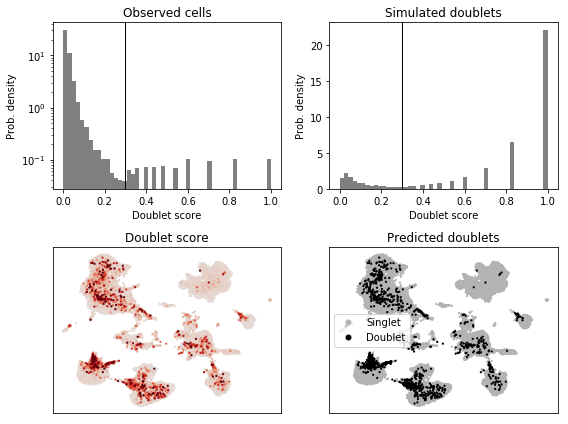

In [29]:
score_threshold = 0.3
fig2, axs = scr.plot_scrublet_results(embedding, doub_score, doub_score_sim, 
                                     score_threshold, order_points=True)

In [17]:
#doub_score
x = cells['Cluster']
y = np.array([x>=0.3 for x in doub_score])
pd.crosstab(x,y)

KeyError: 'Cluster'

In [ ]:
cells['DoubScore'] = doub_score
cells.boxplot(column='DoubScore',by='Cluster')

In [ ]:
# print to file
#from matplotlib.backends.backend_pdf import PdfPages
#pp = PdfPages(condition + '_Doublets.pdf')
#pp.savefig(fig1)
#pp.savefig(fig3)
#pp.savefig(fig2)
#pp.close()